In [1]:
import numpy as np
import pandas as pd

#### Telco churn dataset is from **IBM Base Samples**. This dataset consists of a company's records for each customer; which we will use to predict customer churn rate beforehand. The dataset itself comprises of various continuous and categorical data-types, which we willuse for our assignment.

In [2]:
df = pd.read_excel('Telco_customer_churn.xlsx')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [3]:
df.shape

(7043, 33)

In [4]:
df.drop(columns=['Churn Label','Churn Score','CLTV','Churn Reason'], inplace=True)

##### Some features are unique (country names) so will not be useful in classsification

In [5]:
print(df['Count'].unique())
print(df['Country'].unique())
print(df['State'].unique())

[1]
['United States']
['California']


##### We do not need columns 'Lat Long', 'CustomerID' etc.

In [6]:
df.drop(columns=['Country','State','Count','Lat Long','CustomerID'], inplace=True)

##### We can't have space between the city names, XGBoost does not mind the blank space in between city names (onehotencoding will be done anyway), but we can't build trees later.

In [7]:
df['City'].replace(' ', '_', regex=True, inplace=True)

In [8]:
df.columns = df.columns.str.replace(' ', '_')

In [9]:
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


##### Now we look for missing values

In [10]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

##### Most of the columns are alphabetical or numerical. But upon closer inspection 'Total_Charges' column seems to be numeric but is encoded as object(alphabetical).

In [11]:
df['Total_Charges'].unique()

array([108.15, 151.65, 820.5, ..., 7362.9, 346.45, 6844.5], dtype=object)

1. **It seems some non-numeric data is between the numbers**
2. **We have to locate it and replace it.**

In [12]:
## df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

* **It shows error on line 2234, meaning some value in row 2234 is non-numeric**
* **There might be more than one row of non-numeric data, maybe row 3121 (say)**

In [13]:
len(df[df['Total_Charges'] == ' '])

11

* **There are only 11 rows of missing data/non-numeric data present**

In [14]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = 0

##### Note: Column 'Total_Charges' is still set to object, XGBoost only takes data types of 'float','int','boolean'. So we convert it.

In [15]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df['Total_Charges'].dtype

dtype('float64')

##### We now replace 'space' with '_' in the entire dataset

In [16]:
df.replace(' ', '_', regex = True, inplace = True)

In [17]:
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


#### Now we prepare for XGBoost
1. **First splitting it into input(X) & output (Y)**

In [18]:
X = df.drop(columns=['Churn_Value'])
X.shape

(7043, 23)

In [19]:
Y = df['Churn_Value']

In [20]:
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

**Every column with dtype 'object' needs to be encoded into binary for XGBoost to perform properly**

**We need to see the percentage of people who left the company**

In [21]:
sum(Y)/len(Y)

0.2653698707936959

1. **sum(Y) = total no. of registered customers**
2. **len(Y) = counts only those Y=1 (1 = left company) and doesn't count Y=0 (0 = did not leave company)**
3. **27% of people left the company so the training/testing set should also be divided accordingly**

#### Although the conventional method is to split into training/testing set first then applying transformation of any kind, but we are going to apply transformation first on the entire input set before train-test-split.

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

transformer = ColumnTransformer(transformers = [('tnf1',OneHotEncoder(sparse_output=False),['City','Gender','Senior_Citizen','Partner','Dependents',
                                                                                            'Phone_Service','Multiple_Lines','Internet_Service',
                                                                                            'Online_Security','Online_Backup','Device_Protection',
                                                                                            'Tech_Support','Streaming_TV','Streaming_Movies',
                                                                                            'Contract','Paperless_Billing','Payment_Method'])],
                               remainder = 'passthrough')

In [23]:
X = transformer.fit_transform(X)
X.shape

(7043, 1178)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=13,stratify=Y)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((5282, 1178), (1761, 1178), (5282,), (1761,))

**Check that both the training and testing set is equally split with people leaving the company**

In [25]:
print(sum(Y_train)/len(Y_train))
print(sum(Y_test)/len(Y_test))

0.2654297614539947
0.26519023282226006


In [26]:
import xgboost as xgb

In [27]:
clf = xgb.XGBClassifier(objective='binary:logistic',early_stopping_rounds=10,
            eval_metric='aucpr',seed=42)

In [28]:
clf.fit(X_train,Y_train,
            verbose=True,
            eval_set=[(X_test,Y_test)])

[0]	validation_0-aucpr:0.64334
[1]	validation_0-aucpr:0.64943
[2]	validation_0-aucpr:0.65278
[3]	validation_0-aucpr:0.65938
[4]	validation_0-aucpr:0.67166
[5]	validation_0-aucpr:0.66902
[6]	validation_0-aucpr:0.66744
[7]	validation_0-aucpr:0.66911
[8]	validation_0-aucpr:0.66839
[9]	validation_0-aucpr:0.66133
[10]	validation_0-aucpr:0.66273
[11]	validation_0-aucpr:0.66315
[12]	validation_0-aucpr:0.66541
[13]	validation_0-aucpr:0.66640


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
Y_pred = clf.predict(X_test)

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score

accuracy_score(Y_test,Y_pred)

0.7961385576377058

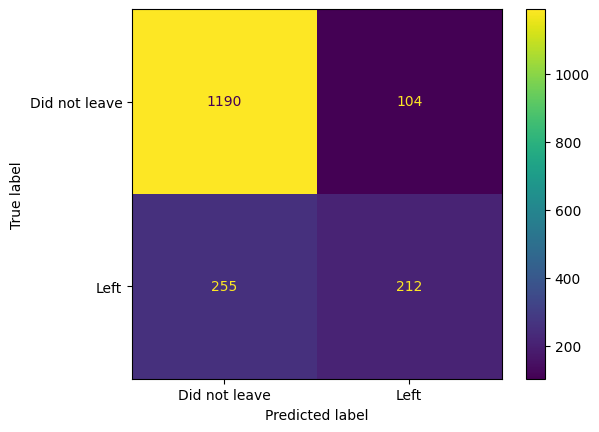

In [31]:
ConfusionMatrixDisplay.from_estimator(clf,
                                      X_test,
                                      Y_test,
                                      values_format='d',
                                      display_labels=['Did not leave','Left'])

#### Out of 1294 people that did not leave, the model correctly classified 1190 (91%). Out of 567 people that left, it correclty classified 212 (45%). The later result could be better, since people leaving costs the company and we want this model to correctly classify those. For this reason we are going to tune the hyper-parameters.

**We will perform a hyperparameter tuning**

In [38]:
params = {'max_depth':[3,4,5],
          'learning_rate':[0.1,0.01,0.05],
          'gamma':[0.01,0.25,0.5],
          'reg_lambda':[1,5,10,15],
          'scale_pos_weight':[3,4,5,6]}

In [39]:
model = RandomizedSearchCV(clf,param_distributions=params,n_iter=15,n_jobs=-1,verbose=20)
model.fit(X_train,Y_train,eval_set=[(X_test,Y_test)])

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[0]	validation_0-aucpr:0.60316
[1]	validation_0-aucpr:0.60731
[2]	validation_0-aucpr:0.61015
[3]	validation_0-aucpr:0.62797
[4]	validation_0-aucpr:0.62822
[5]	validation_0-aucpr:0.63076
[6]	validation_0-aucpr:0.64287
[7]	validation_0-aucpr:0.64501
[8]	validation_0-aucpr:0.65812
[9]	validation_0-aucpr:0.66724
[10]	validation_0-aucpr:0.66948
[11]	validation_0-aucpr:0.67052
[12]	validation_0-aucpr:0.67067
[13]	validation_0-aucpr:0.67355
[14]	validation_0-aucpr:0.67308
[15]	validation_0-aucpr:0.67365
[16]	validation_0-aucpr:0.67810
[17]	validation_0-aucpr:0.67705
[18]	validation_0-aucpr:0.67529
[19]	validation_0-aucpr:0.67646
[20]	validation_0-aucpr:0.67751
[21]	validation_0-aucpr:0.67950
[22]	validation_0-aucpr:0.67834
[23]	validation_0-aucpr:0.67813
[24]	validation_0-aucpr:0.67870
[25]	validation_0-aucpr:0.67896
[26]	validation_0-aucpr:0.67965
[27]	validation_0-aucpr:0.67973
[28]	validation_0-aucpr:0.67856
[29]	validation_0-auc

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=10,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=Non...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'gamma': [0.01, 0.25, 0.5],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': [3, 4, 5],
                                        'reg_lambda': [1, 5, 10, 15],
                                        'scale_pos_weight': [3, 4, 5, 6]},
                   verbose=20)

In [40]:
model.best_params_

{'scale_pos_weight': 3,
 'reg_lambda': 15,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0.01}

In [ ]:
#            'scale_pos_weight': 3,
#            'reg_lambda': 15,
#            'max_depth': 5,
#            'learning_rate': 0.1,
#            'gamma': 0.01

**Above are the parameter values for which I got best results**

In [41]:
new = model.best_estimator_
new.fit(X_train,Y_train,eval_set=[(X_test,Y_test)],verbose=20)

[0]	validation_0-aucpr:0.60316
[20]	validation_0-aucpr:0.67751
[40]	validation_0-aucpr:0.68402
[50]	validation_0-aucpr:0.68329


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

0.7535491198182851


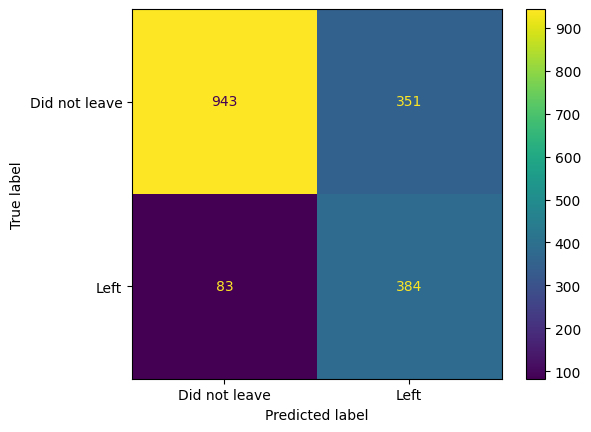

In [42]:
Y_pred = new.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
ConfusionMatrixDisplay.from_estimator(new,X_test,Y_test,values_format='d',
                                     display_labels=['Did not leave','Left'])

**After tuning hyper parameters the model correctly classified 384 (82%) out of 467. Although it came at a cost of correctly classifying the other class 943 (72%) out of 1294. But as a company it may be considered that people leaving has a greater impact which needs to be addressed properly.**